In [1]:
## Processing: LabelTransfer_Wang_GarciaAlonso_Paper
### Vic-Fabienne 16/01/2022

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.17.4 scipy==1.7.3 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.1 pynndescent==0.5.5


In [4]:
project_dir = '/home/vfs/PycharmProjects/Organoids_sc_WS2122'
# project_dir = '../../Organoids_sc_WS2122'
results_file = os.path.join(project_dir, 'results/Tissue_4861STDY7387181.h5ad')  # the file that will store the analysis results

In [5]:
adata = sc.read_h5ad( os.path.join(project_dir, 'data/ReferenceDB/endometrium_all.h5ad'))

In [6]:
adata

AnnData object with n_obs × n_vars = 100307 × 28614
    obs: 'SampleID', 'log2p1_count', 'percent_mito', 'n_genes', 'DonorID', 'BiopsyType', 'Location', 'Binary Stage', 'Stage', 'Broad cell type', 'Cell type', 'CellCycle Phase'
    var: 'gene_ids', 'n_cells'
    uns: 'Binary Stage_colors', 'BinaryStage_colors', 'BiopsyType_colors', 'Broad cell type_colors', 'Cell type_colors', 'CellCycle Phase_colors', 'Day_colors', 'DonorID_colors', 'Location_colors', 'SampleID_colors', 'cosine_logXformedproj_bulkorg_colors', 'cosine_logXformedproj_bulkorg_hormnoinhib_colors', 'cosine_logXformedproj_bulkorg_hormnoinhib_res2_colors', 'cosine_logXformedproj_bulkorg_hormones_colors', 'cosine_logXformedproj_bulkorg_noinhib_colors', 'cosine_logXformedproj_bulkorg_strhormnoinhib_colors', 'cosine_proj_bulkorg_colors', 'cosine_proj_bulkorg_hormnoinhib_colors', 'cosine_proj_bulkorg_hormnoinhib_res2_colors', 'cosine_proj_bulkorg_hormones_colors', 'cosine_proj_bulkorg_noinhib_colors', 'cosine_proj_bulkorg_strhor

In [7]:
print(adata.var[:10])

                      gene_ids  n_cells
RP11-34P13.3   ENSG00000243485       87
FAM138A        ENSG00000237613       17
RP11-34P13.7   ENSG00000238009      209
RP11-34P13.8   ENSG00000239945       17
RP11-34P13.9   ENSG00000241599       11
FO538757.2     ENSG00000279457    15744
AP006222.2     ENSG00000228463     3179
RP5-857K21.15  ENSG00000236743        5
RP4-669L17.2   ENSG00000236601        4
RP4-669L17.10  ENSG00000237094      243


In [8]:
adata.var_names_make_unique()

In [9]:
vec_count_sum_orig = adata.X.sum(axis=1)
vec_count_sum_orig = np.asarray(vec_count_sum_orig).ravel()
print(type(vec_count_sum_orig), vec_count_sum_orig.shape)

<class 'numpy.ndarray'> (100307,)


/tmp/ipykernel_22125/3337822652.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  adata.obs.count_orig = vec_count_sum_orig


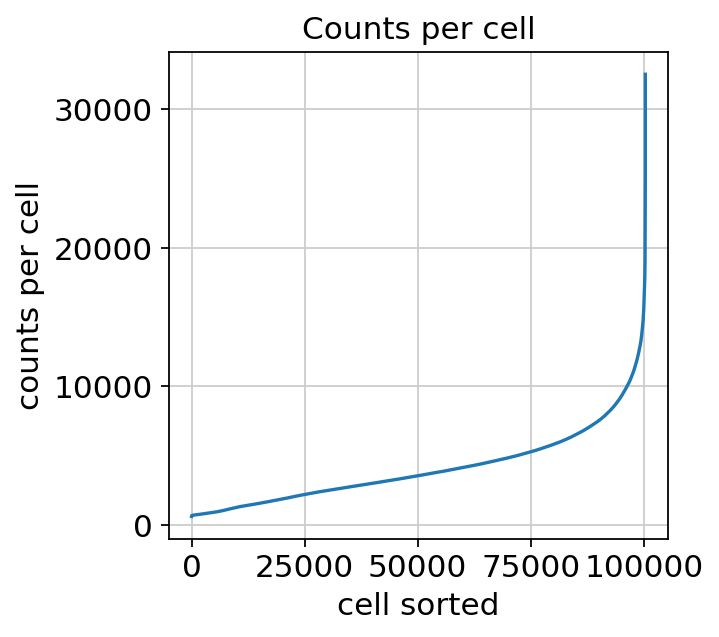

In [11]:
plt.plot( np.sort(vec_count_sum_orig  ) )
plt.xlabel('cell sorted') # what is this? What does it describe?
plt.ylabel('counts per cell')
plt.title('Counts per cell')
adata.obs.count_orig = vec_count_sum_orig

## Preprocessing and conversion from sparse adata.X to dense adata.X using only 10 000 top expressed genes


In [12]:
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')

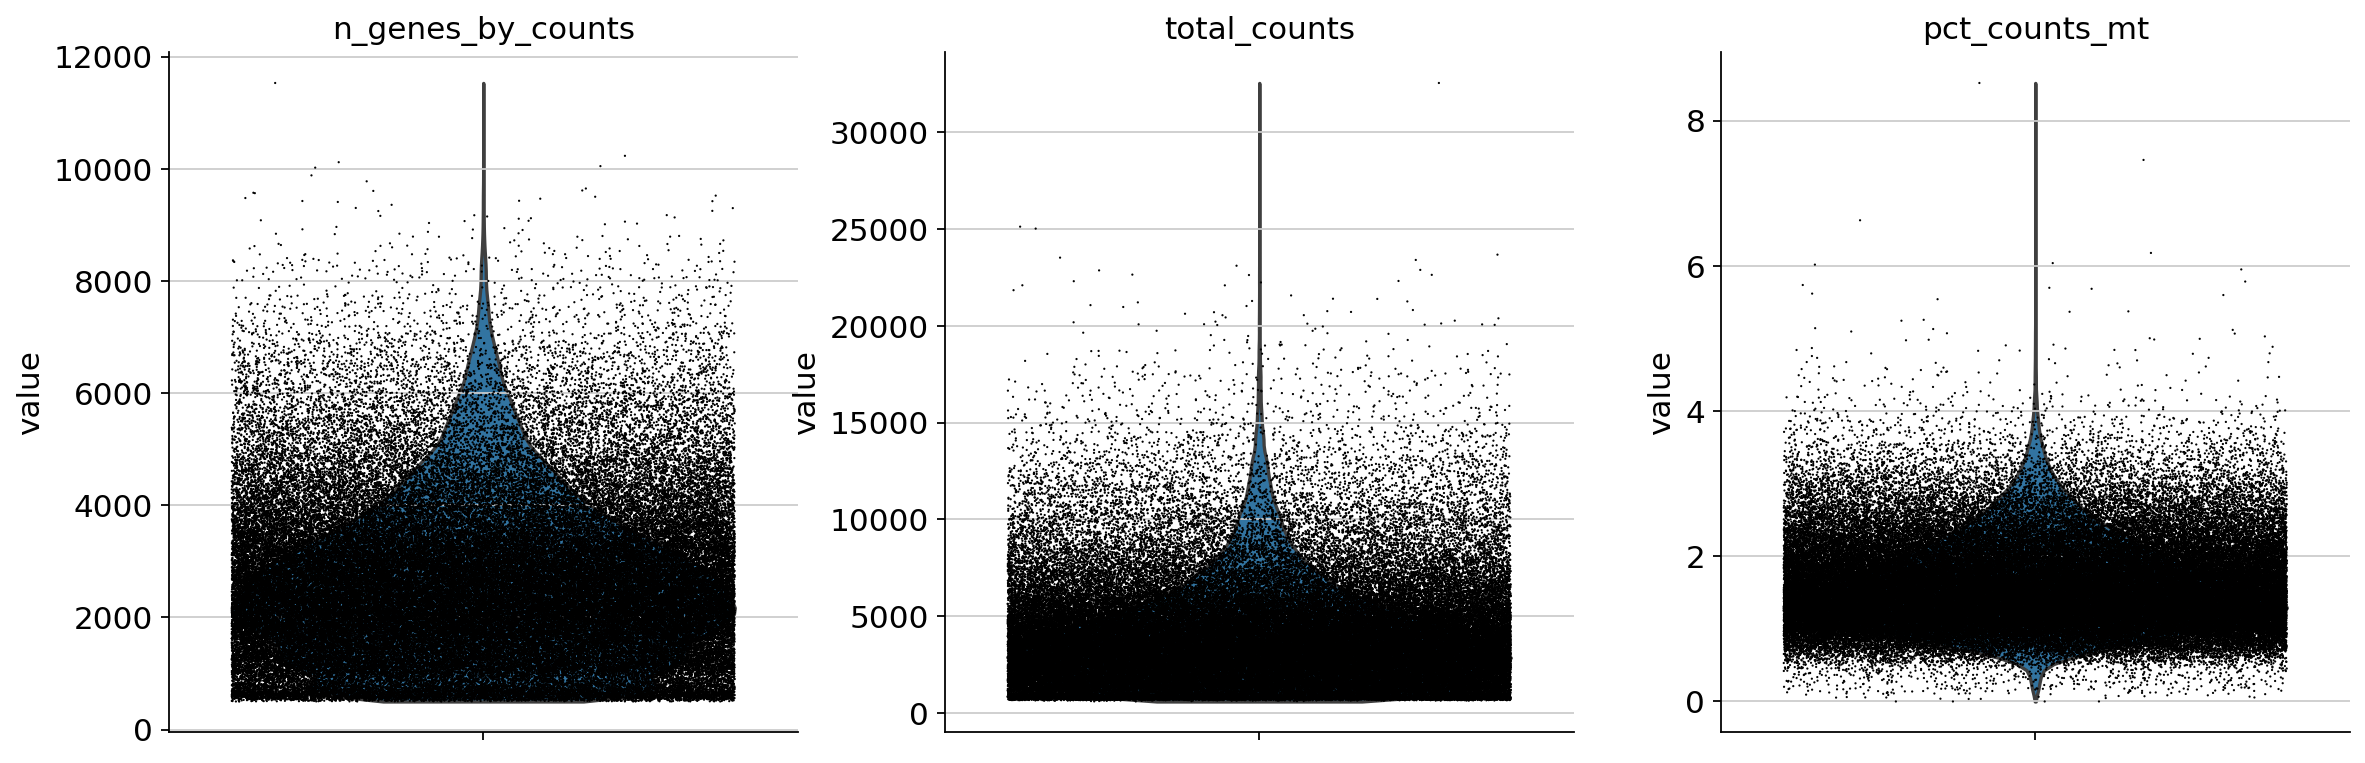

Median total counts = 3551.114
min_count= 500 max_count= 12000


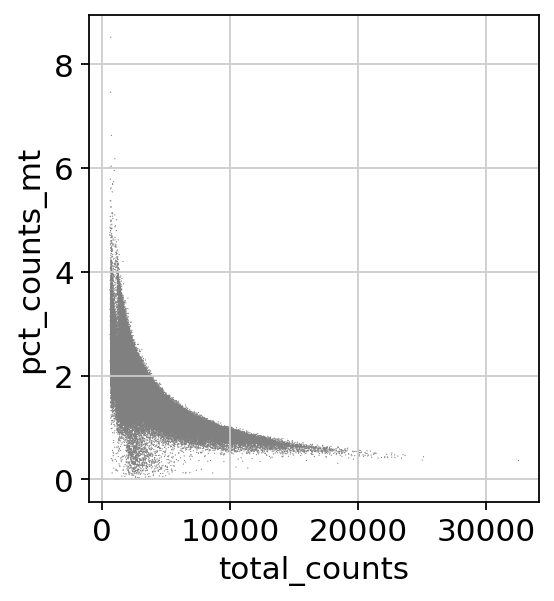

98534 samples pass the count filter
100307  samples pass the mt filter
Samples selected 98534


In [13]:
# sv.pp.remove_duplicate_cells(adata)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

median_count = np.median(adata.obs['total_counts'])
print('Median total counts =',median_count)
min_count = np.max((median_count/2,5000))

min_count = 500
max_count = 12000

print('min_count=',min_count,'max_count=',max_count)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
inds1 = np.where((adata.obs['total_counts']>min_count) & (adata.obs['total_counts']<max_count))
inds2 = np.where(adata.obs['pct_counts_mt']<50)
print(len(inds1[0]),'samples pass the count filter')
print(len(inds2[0]),' samples pass the mt filter')
ind_samples = np.intersect1d(inds1[0],inds2[0])
print('Samples selected',len(ind_samples))
adata.uns['ind_samples'] = ind_samples

In [ ]:
# Here we cut cells. Filtering out those with counts too low or too big
adata = adata[ind_samples,:]

# if False:
#     X = adata.X.T
#     with open(dataset_name+'_umi.txt','w') as f:
#         sample_names = list(adata.obs_names)
#         f.write('GENE\t'+'\t'.join(sample_names)+'\n')
#         print('Number of genes = ',adata.X.shape[1])
#         for i in range(adata.X.shape[1]):
#             vals = [str(X[i,k]).replace('.0','') for k in range(X.shape[1])]
#             f.write(adata.var_names[i]+'\t'+'\t'.join(vals)+'\n')
#     print('Saved.')


sc.pp.normalize_total(adata, target_sum=np.median(adata.obs["total_counts"]))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=10001,n_bins=20)
ind_genes = np.where(adata.var['highly_variable'])[0]

adata = adata[:,ind_genes]
sc.tl.pca(adata,n_comps=30)
X_pca = adata.obsm['X_pca']

adata_orig[ind_samples,ind_genes].var.shape
XX2 = adata_orig[ind_samples,ind_genes].X.toarray()
adata =  anndata.AnnData(XX2,  obs=adata_orig[ind_samples,ind_genes].obs.copy(),
                     var=adata_orig[ind_samples,ind_genes].var.copy() ) #
adata


X_pca1 = X_pca.copy()
X_pca.shape

/home/vfs/PycharmProjects/Organoids_sc_WS2122/PySc/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


NameError: name 'adata' is not defined